# Common Neighbor Rule in PyC Subgraph (Th=0)

In [7]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.graph_creation import *
from utils.common_neighbor_rule import *
from utils.visualization import *

## Create PyC Subgraph

In [8]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_synapses

,pre,post
0,648518346349539437,648518346349531254
1,648518346349537978,648518346349537300
2,648518346349533058,648518346349538715
3,648518346349539333,648518346349539806
4,648518346349523975,648518346349537716
...,...,...
1976,648518346349539110,648518346349538440
1977,648518346349539110,648518346349523993
1978,648518346349539110,648518346349524141
1979,648518346349539110,648518346349539900


In [9]:
pyc_soma = pd.read_csv('data/soma.csv')
pyc_soma

,segmentation,segment_id,manual_id,loc,axon_len,dendrite_len
0,185,648518346349491311,466,[314028 159940 77280],0.000000,1441.069000
1,185,648518346349492130,499,[291484 145484 80960],0.000000,747.483938
2,185,648518346349492197,503,[270948 158088 86240],0.000000,586.186063
3,185,648518346349492682,163,[461372 212624 27640],643.547438,979.816375
4,185,648518346349493472,549,[431864 156576 85720],0.000000,0.000000
...,...,...,...,...,...,...
358,185,648518346349540048,80,[349132 163492 11480],961.385250,1321.124250
359,185,648518346349540051,259,[444892 247424 47480],61.243563,1999.626500
360,185,648518346349540053,102,[446104 253936 18320],56.518617,1612.330500
361,185,648518346349540055,139,[340468 248332 23400],46.961094,3101.869750


In [10]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [11]:
print(nx.info(g_actual))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


In [12]:
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}

In [15]:
g_th0 = get_thresholded_graph(g_actual, axls, 0)
print(nx.info(g_th0))

Name: 
Type: DiGraph
Number of nodes: 229
Number of edges: 1264
Average in degree:   5.5197
Average out degree:   5.5197


## Common Neighbor Rule

In [16]:
%%time
# calculate common neighbor stats in the observation
obs_cnr_stats = get_cnr_stats(g_th0)

CPU times: user 1.58 s, sys: 0 ns, total: 1.58 s
Wall time: 1.59 s


- "undir_pair" - number of pairs with [bin] common neighbor
- "dir_spair" - number of pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_ppair" - number of pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_conn" - number of connected pairs with [bin] common neighbor
- "dir_sconn" - number of connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_pconn" - number of connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_uni_sconn" - number of unidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_uni_pconn" - number of unidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_bi_sconn" - number of bidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_bi_pconn" - number of bidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_perc" - percentage of pairs with [bin] common neighbor to be connected
- "dir_sperc" - percentage of pairs with [bin] strict common successor to be connected
- "dir_pperc" - percentage of pairs with [bin] strict common predcessor to be connected

In [17]:
obs_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,14117.0,23771.0,18044.0,279.0,870.0,683.0,859.0,665.0,11.0,18.0,0.019763,0.036599,0.037852
1,6615.0,1355.0,6061.0,324.0,161.0,387.0,150.0,377.0,11.0,10.0,0.048980,0.118819,0.063851
2,2840.0,566.0,1543.0,231.0,105.0,110.0,96.0,108.0,9.0,2.0,0.081338,0.185512,0.071290
3,1298.0,234.0,373.0,145.0,40.0,40.0,40.0,39.0,0.0,1.0,0.111710,0.170940,0.107239
4,604.0,86.0,69.0,105.0,21.0,9.0,21.0,9.0,0.0,0.0,0.173841,0.244186,0.130435
5,294.0,44.0,13.0,55.0,16.0,4.0,16.0,4.0,0.0,0.0,0.187075,0.363636,0.307692
6,150.0,25.0,3.0,29.0,11.0,0.0,11.0,0.0,0.0,0.0,0.193333,0.440000,0.000000
7,90.0,15.0,0.0,25.0,4.0,0.0,4.0,0.0,0.0,0.0,0.277778,0.266667,0.000000
8,42.0,4.0,0.0,16.0,2.0,0.0,2.0,0.0,0.0,0.0,0.380952,0.500000,0.000000
9,56.0,6.0,0.0,24.0,3.0,0.0,3.0,0.0,0.0,0.0,0.428571,0.500000,0.000000


In [18]:
%%time
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples = continuous_sample_cnr(g_th0, samples=s, niters=int(1e4))


CPU times: user 3min 6s, sys: 248 ms, total: 3min 6s
Wall time: 3min 7s


In [19]:
cfg_cnr_stats, cfg_cnr_stats_std = cnr_mean_std(cfg_cnr_samples)

In [20]:
cfg_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,12370.64,22158.01,16365.49,308.08,881.55,718.11,874.39,706.23,7.16,11.88,0.024904,0.039785,0.043880
1,6657.05,1382.69,6170.50,317.39,178.89,371.62,172.92,364.55,5.97,7.07,0.047681,0.129380,0.060230
2,2931.00,575.85,1562.83,238.23,91.51,116.62,87.74,114.42,3.77,2.20,0.081282,0.158892,0.074616
3,1332.08,234.55,343.75,156.54,44.48,28.49,42.53,28.05,1.95,0.44,0.117517,0.189520,0.082889
4,630.25,95.52,70.86,94.11,21.45,6.11,20.09,5.99,1.36,0.12,0.149353,0.224576,0.085855
5,301.13,41.50,14.13,55.00,11.06,0.99,10.45,0.98,0.61,0.01,0.182876,0.267323,0.071249
6,150.97,20.69,2.82,31.01,6.04,0.29,5.66,0.28,0.38,0.01,0.205050,0.293723,0.078429
7,74.75,10.12,0.54,18.03,3.15,0.02,2.97,0.02,0.18,0.00,0.240615,0.308273,0.015000
8,38.23,5.53,0.05,9.84,1.60,0.02,1.49,0.02,0.11,0.00,0.257501,0.291325,0.020000
9,44.90,6.54,0.03,14.04,2.54,0.00,2.30,0.00,0.24,0.00,0.311413,0.397507,0.000000


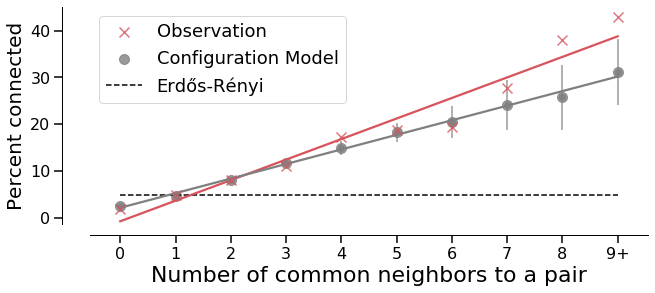

In [21]:
E, N = len(g_th0.edges), len(g_th0.nodes)
ER_p_null = (1 - E / (N*(N-1)))**2

plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null, figsize=(10,4), fname="th0/th0_cnr")

In [22]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.9454235894165766, 2.480767589506469e-06)

In [23]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), cfg_cnr_stats["undir_perc"])

(0.9954090669003594, 1.216917168836621e-10)

## Common Neighbor Rule (Generalized Null Models)

In [24]:
%%time
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples_GE = continuous_sample_cnr_GE(g_th0, samples=s, niters=int(1e4))


CPU times: user 2min 59s, sys: 100 ms, total: 3min
Wall time: 3min


In [25]:
cfg_cnr_stats_GE, cfg_cnr_stats_std_GE = cnr_mean_std(cfg_cnr_samples_GE)

In [26]:
cfg_cnr_stats_GE

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,12465.91,22179.52,16484.86,311.77,882.99,727.80,873.11,710.32,9.88,17.48,0.025009,0.039811,0.044149
1,6668.64,1379.74,6113.97,325.16,175.08,363.36,166.10,353.70,8.98,9.66,0.048755,0.126893,0.059432
2,2907.37,569.81,1517.93,236.55,88.54,109.16,83.23,106.05,5.31,3.11,0.081357,0.155390,0.071922
3,1309.65,226.08,330.27,153.59,43.27,26.48,40.27,25.88,3.00,0.60,0.117270,0.191097,0.080167
4,606.86,94.04,67.89,89.28,20.68,5.01,19.12,4.87,1.56,0.14,0.147098,0.220271,0.074422
5,289.42,41.77,12.98,52.23,10.37,0.93,9.30,0.93,1.07,0.00,0.180376,0.249038,0.069730
6,140.97,19.55,2.67,28.37,5.46,0.24,4.93,0.23,0.53,0.01,0.201369,0.281404,0.067524
7,68.90,9.22,0.35,15.96,3.04,0.02,2.74,0.02,0.30,0.00,0.230728,0.333356,0.020000
8,34.09,5.02,0.06,8.69,1.46,0.00,1.34,0.00,0.12,0.00,0.252432,0.299817,0.000000
9,39.19,6.25,0.02,11.40,2.11,0.00,1.86,0.00,0.25,0.00,0.286711,0.342129,0.000000


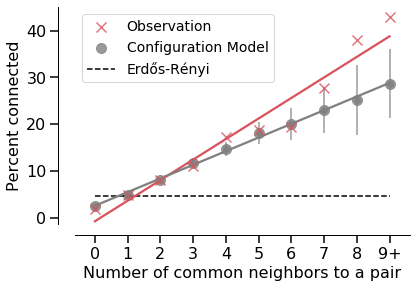

In [27]:
_, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th0)
ER_p_null_GE = 1 - 2*two_pr_GE["pr_uni"] - two_pr_GE["pr_bi"]

plot_cnr(obs_cnr_stats, cfg_cnr_stats_GE, cfg_cnr_stats_std_GE, ER_p_null_GE, 
         figsize=(6,4), fontsizes=(16, 16, 16, 14), fname="th0/th0_cnr_GE")

In [28]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.9454235894165766, 2.480767589506469e-06)

In [29]:
# Pearson r^2 and p-value
pearson_r2(np.arange(10), cfg_cnr_stats_GE["undir_perc"])

(0.9970342430779174, 2.1179521343832084e-11)

## Generate Plots

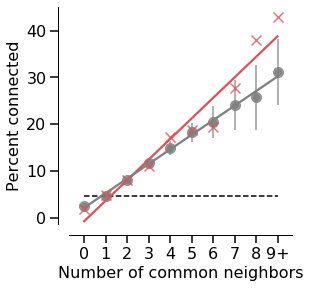

In [38]:
plot_cnr_adapt(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null_GE, 
         figsize=(4,4), fontsizes=(16, 16, 16, 14), fname="th0/th0_cnr_CGE")